## Processamento de Linguagem Natural (PLN)
### Análise de Sentimentos - Twitter

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk # pip install nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# pip install wordcloud
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\TOP
[nltk_data]     Artes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\TOP
[nltk_data]     Artes\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Ler os dados

In [2]:
train = pd.read_csv('CSVs/twitter/train.csv')
test = pd.read_csv('CSVs/twitter/test.csv')
train.shape, test.shape

((31962, 3), (17197, 2))

In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


### Pré-Processar os Dados
#### Tirar as pontuações e caracteres especiais

In [4]:
def text_clear(df:pd.DataFrame, col:str):
    """
    Recebe Dataframe (df) e remove os caracteres especiais da coluna específica (col)
    """
    df[col] = df[col].str.lower()\
    .apply(lambda x: re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?','',x))\
    .str.split()


In [5]:
text_clear(train, 'tweet')
train.head()

,id,label,tweet
0,1,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,2,0,"[thanks, for, lyft, credit, i, cant, use, caus..."
2,3,0,"[bihday, your, majesty]"
3,4,0,"[model, i, love, u, take, with, u, all, the, t..."
4,5,0,"[factsguide, society, now, motivation]"


In [6]:
text_clear(test, 'tweet')
test.head()

,id,tweet
0,31963,"[studiolife, aislife, requires, passion, dedic..."
1,31964,"[white, supremacists, want, everyone, to, see,..."
2,31965,"[safe, ways, to, heal, your, acne, altwaystohe..."
3,31966,"[is, the, hp, and, the, cursed, child, book, u..."
4,31967,"[3rd, bihday, to, my, amazing, hilarious, neph..."


#### Remover palavras comuns

In [7]:
def check_summary(df:pd.DataFrame, col:str):
    """
    Recebe Dataframe (df) e remove todas as palavras contidas no sumário da coluna específica (col)
    """
    summary = stopwords.words('english')
    for idx, _ in df.iterrows():
        df[col].at[idx] = [word for word in df.iloc[idx][col] \
                           if word not in summary]

In [8]:
def check_word_variation(df:pd.DataFrame, col:str):
    """
    Recebe Dataframe (df) e converte para o infinitivo as variações dos verbos da coluna específica (col)
    """
    wnl = WordNetLemmatizer()
    for idx, _ in df.iterrows():
        df[col].at[idx] = [wnl.lemmatize(word,'v') \
                           for word in df.iloc[idx][col]]

In [9]:
check_summary(train, 'tweet')

In [10]:
check_summary(test, 'tweet')

In [11]:
check_word_variation(train, 'tweet')

In [12]:
check_word_variation(test, 'tweet')

### Engenharia de Recursos (Feature Engineering)
#### Quantidade de palavras por tweet

In [13]:
train['qtd_palavras'] = train['tweet'].apply(len)
test['qtd_palavras'] = test['tweet'].apply(len)
train.head()

,id,label,tweet,qtd_palavras
0,1,0,"[father, dysfunctional, selfish, drag, kid, dy...",7
1,2,0,"[thank, lyft, credit, cant, use, cause, dont, ...",13
2,3,0,"[bihday, majesty]",2
3,4,0,"[model, love, u, take, u, time, ur]",7
4,5,0,"[factsguide, society, motivation]",3


## Análise Exploratória de Dados (AED)
### Distribuição das quantidades de palavras por "label"

In [14]:
def plot_size():
    fig = plt.gcf()
    fig.set_size_inches(10,6)
    fig.set_dpi(150)

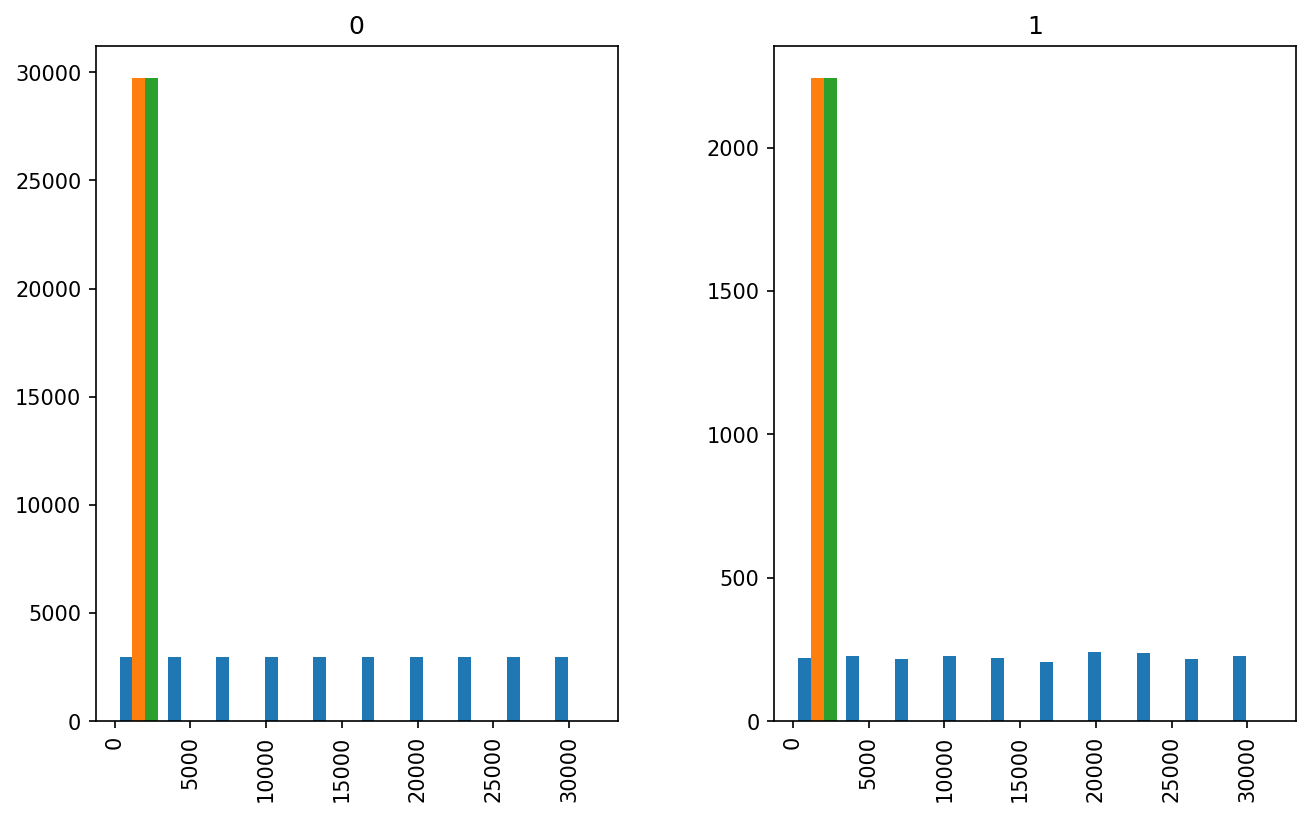

In [15]:
ax = train.hist(column=['qtd_palavras'], by='label')
plot_size()
plt.show()

### Quantidade de cada "label"

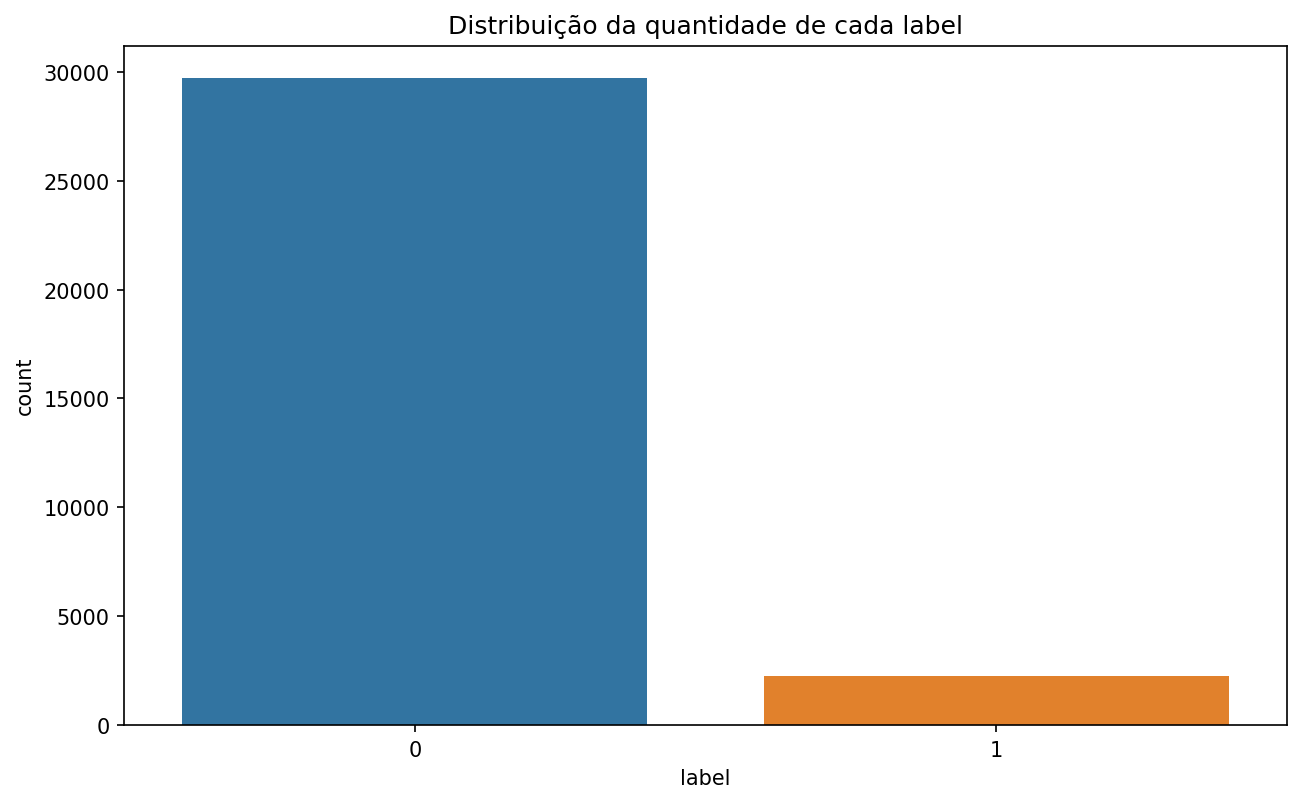

In [16]:
sns.countplot('label', data=train)
plot_size()
plt.title('Distribuição da quantidade de cada label')
plt.show()

### Palavras frequêntes
#### Averiguar as palavras mais frenquêntes em mensagens classificadas como "racistas ou sexistas"

In [17]:
def word_counter(words:list)->dict:
    
    def sum_words(dct:dict, word:str, msg:list):
        dct[word] = dct[word] + msg.count(word)

    dct_words = {word:0 for msg in  words for word in msg}
    
    for msg in words:
        [sum_words(dct_words, word, msg) for word in msg]
    
    return dct_words

In [18]:
dct_words = word_counter(train.loc[train['label']==1]['tweet'].values)

### Nuvem de palavras

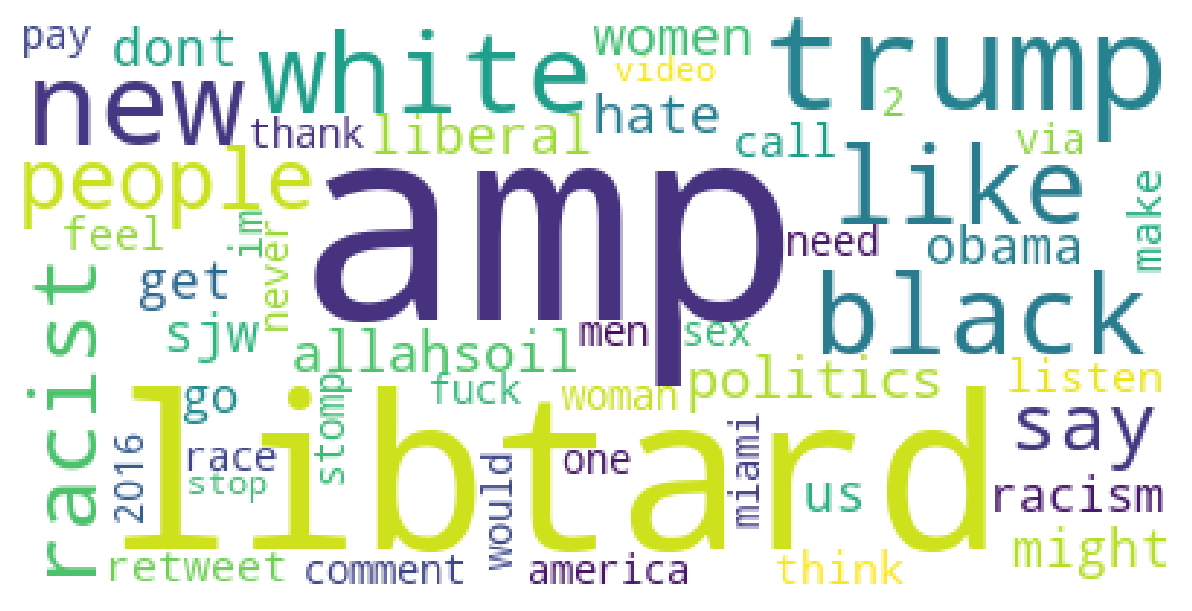

In [19]:
nuvem = WordCloud(background_color='white')
nuvem.generate_from_frequencies(
    dict(sorted(dct_words.items(), key=lambda x: x[1], reverse=True)[:50]))

plt.imshow(nuvem)
plt.axis('off')
plot_size()
plt.show()

### Retornar texto ao formato original

In [20]:
train['tweet'] = train['tweet'].apply(lambda x: ' '.join(x))
test['tweet'] = test['tweet'].apply(lambda x: ' '.join(x))

### Solucionar problema de desequilíbrio dos dados

In [21]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [22]:
def balance_df(df:pd.DataFrame, biger:bool=True):
    if biger:
        min_max = resample(train.loc[train['label']==1],
                           replace = True,
                           n_samples = len(train.loc[train['label']==0]),
                           random_state=123)
        return pd.concat([min_max, train.loc[train['label']==0]])
    else:
        max_min = resample(train.loc[train['label']==0],
                   replace = True,
                   n_samples = len(train.loc[train['label']==1]),
                   random_state=123)
        return pd.concat([max_min, train.loc[train['label']==1]])

In [48]:
train_equi = balance_df(train, biger=True)
train_equi['label'].value_counts()

1    29720
0    29720
Name: label, dtype: int64

In [49]:
X = train_equi['tweet']
y = train_equi['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)
X_train.shape, y_train.shape

((41608,), (41608,))

In [50]:
X_test.shape, y_test.shape

((17832,), (17832,))

In [51]:
sgd = Pipeline([
    ('countVector', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('modelo', SGDClassifier())
])

In [52]:
sgd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('countVector',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabul...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000,

In [53]:
sgd_pred = sgd.predict(X_test)
sgd_pred

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [54]:
sgd_score = f1_score(y_test, sgd_pred)
sgd_score

0.9675780171223418

In [56]:
y_pred = sgd.predict(test['tweet'])
y_pred

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

### Submissão Vidhya

In [57]:
submissao = pd.DataFrame({'id':test['id'], 'label':y_pred})
submissao.head()

,id,label
0,31963,0
1,31964,1
2,31965,0
3,31966,0
4,31967,0


In [58]:
submissao.to_csv('CSVs/twitter/pred_twitter.csv', index=False)